In [2]:
import torch
from torch_snippets import *
from torchvision import datasets

data_folder = '~/cifar10/cifar/'
datasets.CIFAR10(data_folder, download=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting C:\Users\Наиль/cifar10/cifar/cifar-10-python.tar.gz to C:\Users\Наиль/cifar10/cifar/


In [6]:
class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)
        
    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw)/255.,np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw,im]]
        return bw, im

In [7]:
trn_ds = Colorize('~/cifar10/cifar/', train=True)
val_ds = Colorize('~/cifar10/cifar/', train=False)

trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)

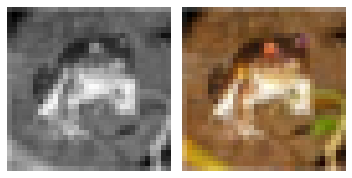

In [8]:
a,b = trn_ds[0]
subplots([a,b], nc=2)

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
class DownConv(nn.Module):
    def __init__(self,ni,no,maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPoll2d(2) if maxpoll else Identiry(),
            nn.Conv2d(ni,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),)
    
    def forward(self,x):
        return self.model(x)
    

class UpConv(nn.Module):
    def __init__(self,ni,no,maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni,no,2,stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2,inplace=True),)
        
    def forward(self,x,y):
        x = self.convtraspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x
    

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv(3,64,maxpool=False)
        self.d2 = DownConv(64,128)
        self.d3 = DownConv(128,256)
        self.d4 = DownConv(256,512)
        self.d5 = DownConv(512,1024)
        self.u5 = UpConv(1024,512)
        self.u4 = UpConv(512,256)
        self.u3 = UpConv(256,128)
        self.u2 = UpConv(128,64)
        self.u1 = nn.Conv2d(64,3,kernel_size=1,stride=1)
        
    def forward(self,x):
        x0 = self.d1( x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        X4 = self.u5(x4,x3)
        X3 = self.u4(X4,x2)
        X2 = self.u3(X3,x1)
        X1 = self.u2(X2,x0)
        X0 = self.u1(X1)
        return X0

In [10]:
def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [11]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    x, y = data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y,y)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    x, y = data
    _y = model(x)
    loss = criterion(_y,y)
    return loss.item()

In [ ]:
model, optimizer, criterion = get_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

_val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

n_epochs = 100
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')
        if (bx+1)%50 == 0:
            for _ in range(5):
                a, b = next(iter(_val_dl))
                _b = model(a)
                subplots([a[0], b[0], _b[0]],nc=3,figsize=(5,5))
    
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss,end='\r')
    exp_lr_scheduler.step()
    if (ex+1) % 5 == 0:
        log.report_avgs(ex+1)
        
    for _ in range(5):
        a,b = next(iter(_val_dl))
        _b = model(a)
        subplots([a[0], b[0], _b[0]], nc=3, figsize=(5,5))

log.plot_epochs()